In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
import matplotlib.pyplot as plt
%matplotlib inline 
import math
import tensorflow as tf
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
batch_size=24

In [3]:
train_folder = '/content/drive/MyDrive/Projects/flower_category_prediction/flower_dataset/train'
labels = os.listdir(train_folder)
num_classes = len(set(labels))
image_size = 224
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    horizontal_flip=True,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical'
    )

Found 1190 images belonging to 17 classes.


In [4]:
train_folder = '/content/drive/MyDrive/Projects/flower_category_prediction/flower_dataset/train'
labels = os.listdir(train_folder)
num_classes = len(set(labels))
image_size = 224
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    horizontal_flip=True,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    validation_split=0.2)# set validation split

train_generator = data_generator.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical',
    subset='training'
    )
validation_generator = data_generator.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical',
    subset='validation'
    )

Found 952 images belonging to 17 classes.
Found 238 images belonging to 17 classes.


In [5]:
test_folder = '/content/drive/MyDrive/Projects/flower_category_prediction/flower_dataset/test'
test_generator = data_generator.flow_from_directory(
    test_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical'
    )

Found 170 images belonging to 17 classes.


In [6]:
# Create model
model = Sequential()
base_model = ResNet50(include_top=False, pooling='avg', weights='imagenet')
model.add(base_model)
model.add(Dense(256, activation='relu'))
model.add(Dropout(.5))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))
# Do not train first layer (ResNet) as it is already pre-trained
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 500

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# Compile model
sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Number of layers in the base model:  176
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 17)                4369      
Total params: 24,117,649
Trainable params: 529,425
Non-trainable params: 23,588,224
________________________________________________________________

In [ ]:
NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 5
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction


cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '/content/drive/MyDrive/Projects/flower_category_prediction/customized_best.hdf5',
                                  monitor = 'val_loss',
                                  save_best_only = True,
                                  mode = 'auto')

fit_history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    validation_data=validation_generator,
    validation_steps=10,
    epochs=NUM_EPOCHS,
    callbacks=[cb_checkpointer, cb_early_stopper])
model.load_weights("/content/drive/MyDrive/Projects/flower_category_prediction/customized_best.hdf5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
10/10 [==============================] - 57s 6s/step - loss: 2.9441 - accuracy: 0.1328 - val_loss: 1.8818 - val_accuracy: 0.4118
Epoch 2/50
10/10 [==============================] - 52s 5s/step - loss: 1.6124 - accuracy: 0.5000 - val_loss: 1.3598 - val_accuracy: 0.5798
Epoch 3/50
10/10 [==============================] - 53s 6s/step - loss: 1.1916 - accuracy: 0.6685 - val_loss: 0.9097 - val_accuracy: 0.7479
Epoch 4/50
10/10 [==============================] - 53s 6s/step - loss: 0.9225 - accuracy: 0.7734 - val_loss: 0.8075 - val_accuracy: 0.7815
Epoch 5/50
10/10 [==============================] - 52s 5s/step - loss: 0.7999 - accuracy: 0.7757 - val_loss: 0.7018 - val_accuracy: 0.8025
Epoch 6/50
10/10 [==============================] - 53s 6s/step - loss: 0.7051 - accuracy: 0.8621 - val_loss: 0.6248 - val_accuracy: 0.8235
Epoch 7/50
10/10 [==============================] - 53s 6s/step - loss: 0.5563 - accuracy: 0.8765 - val_loss: 0.5199 - val_accuracy: 0.8361
Epoch 8/50
10/10 [==

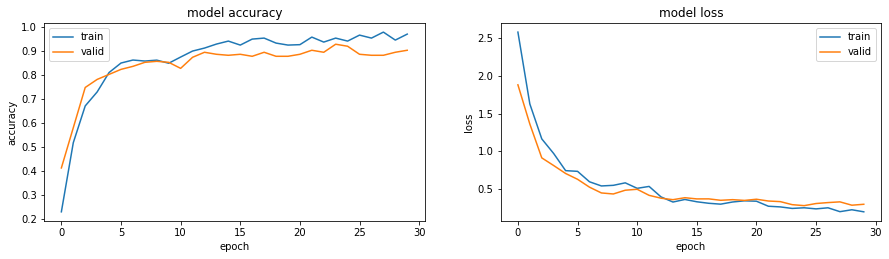

In [ ]:
plt.figure(1, figsize = (15,8)) 
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.show()

In [ ]:
train_steps = train_generator.n // batch_size
val_steps = validation_generator.n // batch_size
test_steps = test_generator.n // batch_size
# evaluate performance on train, cross-val & test datasets
loss, acc = model.evaluate_generator(train_generator, steps=train_steps, verbose=1, workers=3)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(validation_generator, steps=val_steps, verbose=1, workers=3)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(test_generator, steps=test_steps, verbose=1, workers=3)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


39/39 [==============================] - 105s 3s/step - loss: 0.1037 - accuracy: 0.9808
Training data  -> loss: 0.104, acc: 0.981
9/9 [==============================] - 24s 2s/step - loss: 0.2870 - accuracy: 0.9259
Cross-val data -> loss: 0.287, acc: 0.926
7/7 [==============================] - 18s 2s/step - loss: 0.6293 - accuracy: 0.7917
Testing data   -> loss: 0.629, acc: 0.792
